# Intro to uplift modelling

## Overview

This notebook demonstrates the process of generating some synthetic data for causal inference problems.

The diagram below shows how the profit from a customer is related to other factors.
- Profit is the outcome we are interested in.
- Promotion is believed to have a direct impact on the profit. The impact of a promotion also varies based on the average amount of previous orders.
- Profit is also associated with three factors.
  - The income of a customer.
  - The average amount of previous orders.
  - The number of years since registration.

  
Below is a more formal mathematical representation.
- $ y = TE * t + a * x_1 + b * x_2 + c * x_3$
- $ TE = d * x_2^2$

<img src="diagrams/uplift_modelling.md.1.png">

In [2]:
import pandas as pd
import numpy as np
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

num_samples = 10000
np.random.seed(42)
x1 = abs(np.random.normal(loc=3000, scale=1500, size=num_samples))
x2 = abs(np.random.normal(loc=50, scale=10, size=num_samples))
x3 = abs(np.random.randn(num_samples) + 3) + 0.01
t = np.random.randint(low=0, high=2, size=num_samples)

a = 0.01
b = 0.3
c = 3
d = 2.68

TE = d * x2**2 / 1000
Y = TE * t + a * x1 + b * x2 + c * x3

df = pd.DataFrame({'income': x1, 'avg_order': x2, 'yrs': x3, 'promotion': t, 'TE': TE, 'profit': Y})
df.describe().transpose().drop(columns='count').applymap(lambda x: round(x, 2))

,mean,std,min,25%,50%,75%,max
income,3022.98,1451.88,1.67,1992.69,2996.11,4006.62,8889.36
avg_order,50.14,10.01,11.44,43.38,50.16,56.94,94.79
yrs,3.00,0.99,0.02,2.31,3.00,3.67,6.70
promotion,0.49,0.50,0.00,0.00,0.00,1.00,1.00
TE,7.00,2.72,0.35,5.04,6.74,8.69,24.08
profit,57.73,15.93,15.44,46.43,57.45,68.44,128.91


In [3]:
print('distribution of promotion')
df['promotion'].value_counts()

distribution of promotion


promotion
0    5061
1    4939
Name: count, dtype: int64

In [4]:
df.head()

,income,avg_order,yrs,promotion,TE,profit
0,3745.071230,43.215053,3.358286,1,5.005009,65.495096
1,2792.603548,46.945005,3.293324,1,5.906274,57.795782
2,3971.532807,44.026189,2.073480,1,5.194658,64.338284
3,5284.544785,51.104180,3.589584,1,6.999188,85.944643
4,2648.769938,61.971785,1.519917,0,10.292546,49.638987


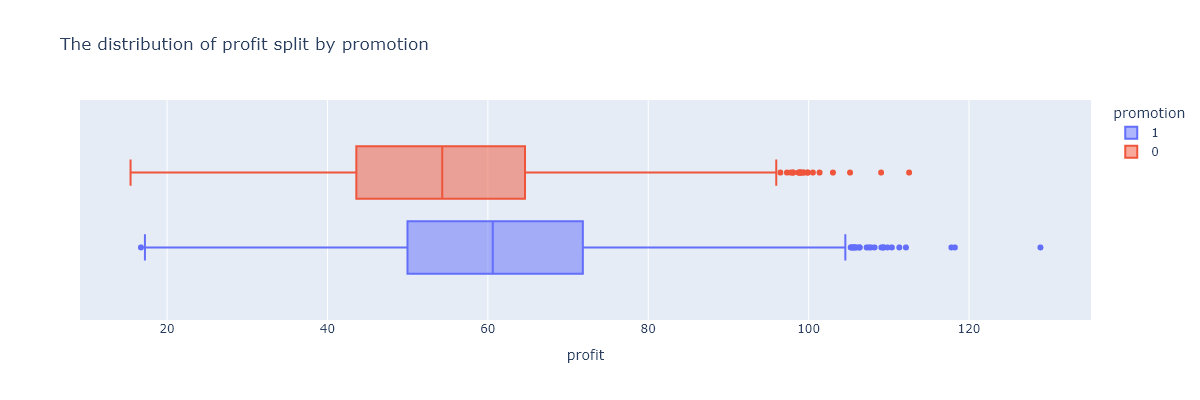

In [41]:
px.box(df, x='profit', color='promotion', width=1200, height=400, title='The distribution of profit split by promotion').write_image('diagrams\promotion_dist.png')
Image('diagrams/promotion_dist.png')

## Treatment effect estimation

In many scenarios, we want to find out the uplift/increase in profit from a customer that is driven by promotions. It is equivalent to estimating the treatment effect of running a promotion on a customer. 

Since the treatment effect varies based on another attribute, it means that the treatment effect is heterogeneous and we want to model conditional average treatment effects (CATE). Being able to do that would enable us to identify the groups of customers who respond positively to promotions, which means that we would be able to run more sophisticated campaigns to maximise the return.

The more professional term describing the process above is **uplift modelling**. There are several algorithms we can use. I will start with talking about meta learner.

### Meta learner

Meta learner is a technique that integrates information from one or multiple machine learning models to generate combined estimate of causal effects. It includes S-learner, T-learner, X-learner. 
We will be utilising the implementation of EconML.

#### S-learner​
- Train only one model M() using both treated and control samples.
- Takes both the treatment T and features X to predict the outcome.​
- Scoring: the treatment effect is M(X|T=1) - M(X|T=0)

<img src="diagrams/uplift_modelling.md.2.png">


In [7]:
from econml.metalearners import SLearner, TLearner
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

t = df['promotion'].to_numpy()
X = df[['income', 'avg_order', 'yrs']].to_numpy()
y = df['profit'].to_numpy()
TE = df['TE'].to_numpy()

X_train, X_test, y_train, y_test, t_train, t_test, TE_train, TE_test = train_test_split(X, y, t, TE, stratify=t, random_state=42)

In [8]:
for matrix, name in zip([X_train, X_test, y_train, y_test, t_train, t_test, TE_train, TE_test], ['X_train', 'X_test', 'y_train', 'y_test', 't_train', 't_test', 'TE_train', 'TE_test']):
    print(name+' shape: ', matrix.shape)

X_train shape:  (7500, 3)
X_test shape:  (2500, 3)
y_train shape:  (7500,)
y_test shape:  (2500,)
t_train shape:  (7500,)
t_test shape:  (2500,)
TE_train shape:  (7500,)
TE_test shape:  (2500,)


In [9]:
df_test = pd.DataFrame(X_test, columns=['income', 'avg_order', 'yrs'])
df_test['TE_test'] = TE_test
df_test.head()

,income,avg_order,yrs,TE_test
0,2256.182742,47.746519,1.542728,6.109677
1,7152.560408,54.992585,3.113768,8.104814
2,2968.132831,65.329782,2.041038,11.438188
3,776.404820,50.436401,3.041080,6.817466
4,5980.913999,52.315411,4.121376,7.334898


In [10]:
slearner = SLearner(overall_model=RandomForestRegressor(random_state=42))
slearner.fit(Y=y_train, T=t_train, X=X_train)
TE_slearner = slearner.effect(X_test)
df_test['TE_slearner'] = TE_slearner

#### T-learner
- Handle regularisation bias issue from S-learner​
- Train two models F_1() and F_0(). F_1 uses treated samples, F_0 uses control samples.​
- Both model take only features X to predict the outcome Y.​
- Scoring: the treatment effect is F_1(X) - F_0(T=0)​

<img src="diagrams/uplift_modelling.md.3.png">


In [12]:
tlearner = TLearner(models=RandomForestRegressor(random_state=42))
tlearner.fit(Y=y_train, T=t_train, X=X_train)
TE_tlearner = tlearner.effect(X_test)
df_test['TE_tlearner'] = TE_tlearner

### DML

The next algorithm is DML, a two-stage framework to estimate causal parameters, offers great flexibility to choose first and second stage models.​ It is good at handling regularisation bias and confounding bias​.

- Stage 1: Partialling-out phase (remove the effects from confounders in treatment and outcome)
- Stage 2: Heterogeneity modelling phase (regress y_res using t_res and features)​

In this exercise, I will be using one of the variants called CausalForsetDML implemented in EconML.
<img src="diagrams/uplift_modelling.md.4.png">
<img src="diagrams/uplift_modelling.md.5.png">


In [15]:
from econml.dml import CausalForestDML
from sklearn.ensemble import RandomForestClassifier

cfdml = CausalForestDML(model_y=RandomForestRegressor(random_state=42),
                        model_t=RandomForestClassifier(random_state=42),
                        discrete_treatment=True)

cfdml.fit(Y=y_train, T=t_train, X=X_train)
TE_cfdml = cfdml.effect(X_test)
df_test['TE_cfdml'] = TE_cfdml

### Comparison

In this section, the prediction results are assessed via looking at various metrics, such as correlation score, root mean square error, etc.

The correlation and rmse table below shows the TE predicted by causalForestDML is a lot closer to the ground truth. The performance between s-learner and t-learner is not quite noticeable.

In [16]:
corr_scores = pd.DataFrame.corr(df_test[['TE_test', 'TE_slearner', 'TE_tlearner', 'TE_cfdml']]).iloc[0, 1:4].to_numpy()
rmse_scores = [np.sqrt(mean_squared_error(TE_test, df_test[col])) for col in ['TE_slearner', 'TE_tlearner', 'TE_cfdml']]

df_scores = pd.DataFrame({'correlation with TE_test': corr_scores, 'rmse': rmse_scores})
df_scores.index = ['TE_slearner', 'TE_tlearner', 'TE_cfdml']
df_scores

,correlation with TE_test,rmse
TE_slearner,0.964588,0.816356
TE_tlearner,0.957411,0.867265
TE_cfdml,0.995627,0.259265


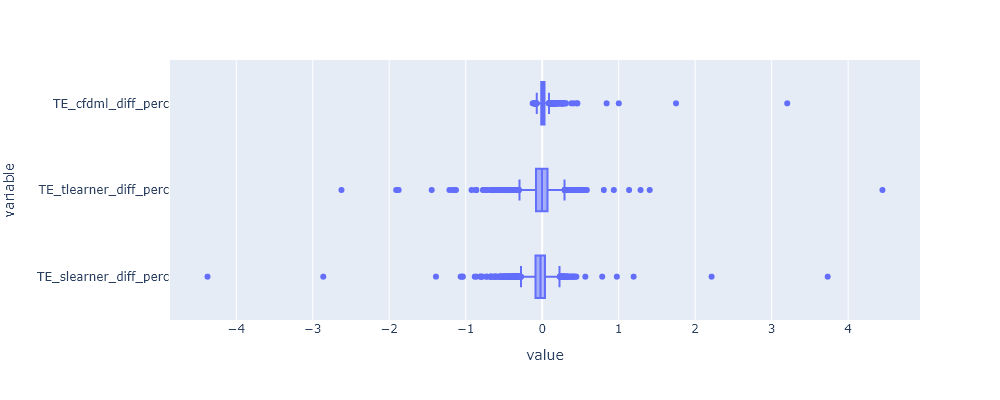

In [42]:
for col in ['TE_slearner', 'TE_tlearner', 'TE_cfdml']:
    df_test[f'{col}_diff_perc'] = (df_test[col] - df_test['TE_test'])/df_test['TE_test']

px.box(df_test, x=df_test.columns[-3:], width=1000, height=400).write_image('diagrams\diff_perc.png')
Image('diagrams/diff_perc.png')

In [30]:
df_test[df_test.columns[-3:]].describe().transpose().drop(columns='count').applymap(lambda x: round(x,2))

,mean,std,min,25%,50%,75%,max
TE_slearner_diff_perc,-0.04,0.20,-4.38,-0.09,-0.02,0.04,3.73
TE_tlearner_diff_perc,-0.01,0.20,-2.62,-0.08,-0.00,0.07,4.45
TE_cfdml_diff_perc,0.02,0.09,-0.12,-0.01,0.01,0.03,3.20


Since we know the ground truth of TE which only varies with the average amount of previous orders, we can visualise the TE predicted vs average amount as below.

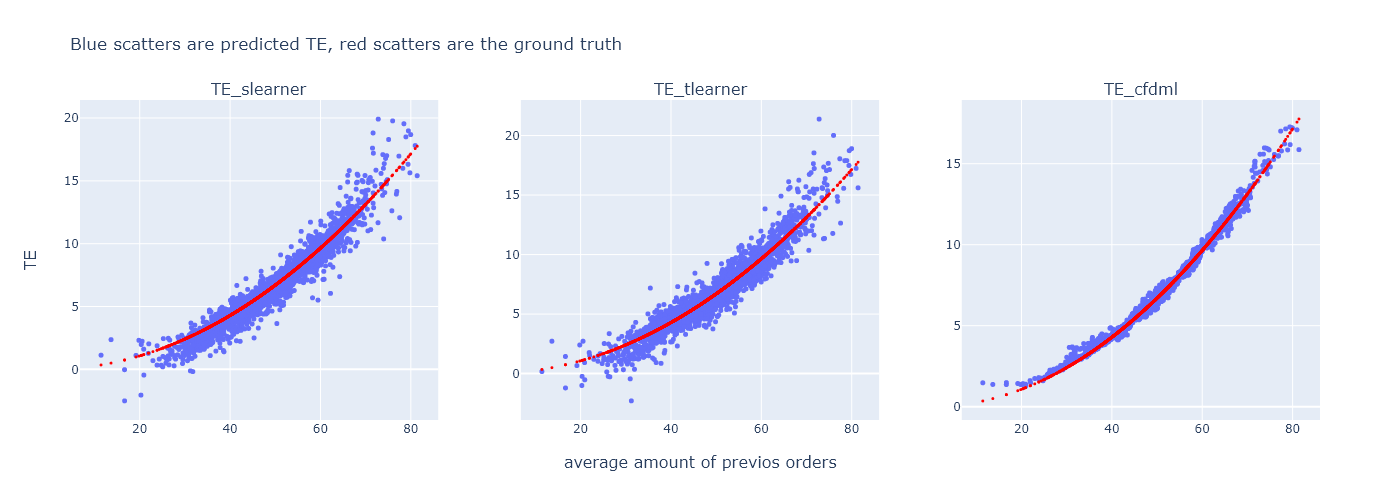

In [107]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(rows=1, cols=3, x_title='average amount of previos orders', y_title='TE', column_titles=['TE_slearner', 'TE_tlearner', 'TE_cfdml'])

for idx, col in zip([1,2,3], ['TE_slearner', 'TE_tlearner', 'TE_cfdml']):
    fig.add_trace(go.Scatter(x=df_test['avg_order'], y=df_test[col], mode='markers', name=col, marker=dict(color='#636efa', size=5)), row=1, col=idx)
    fig.add_trace(go.Scatter(x=df_test['avg_order'], y=df_test['TE_test'], mode='markers', name='TE_test', marker=dict(color='red', size=3)), row=1, col=idx)

fig.update_layout(width=1400, height=500, showlegend=False, title='Blue scatters are predicted TE, red scatters are the ground truth').write_image('diagrams\comparison.png')
Image('diagrams/comparison.png')

It's clear that CausalForestDML can accurately estimate heterogeneous treatment effect but how about the scenario where we are only interested in the average treatment effect between treatment and control group.

Therefore, by taking the average of the predicted TE, we find that t-learner and CausalForestDML have similar performance (6.923-TE_tlearner, 6.996-TE_cfdml, 6.943-TE_test).

In [115]:
df_test[['TE_test', 'TE_slearner', 'TE_tlearner', 'TE_cfdml']].describe().transpose().drop(columns='count').applymap(lambda x: round(x,3))

,mean,std,min,25%,50%,75%,max
TE_test,6.943,2.716,0.351,4.969,6.707,8.658,17.759
TE_slearner,6.785,2.978,-2.509,4.852,6.472,8.481,19.913
TE_tlearner,6.923,2.971,-2.292,4.926,6.542,8.728,21.381
TE_cfdml,6.996,2.706,1.248,4.940,6.705,8.546,17.268
